In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import json 
import networkx as nx

with open("rot_mnist_30_clients_50_participation_sim_logs_global_eval_final.json", "r") as f:
    d = json.load(f)

print(d.keys())

dict_keys(['logs', 'similarity_logs', 'config'])


In [2]:

similarities = d['similarity_logs'] 
# Sort keys to ensure correct order
sorted_keys = sorted(similarities.keys())


In [3]:

def plot_all_matrices(matrices_dict):
    """Plot all matrices in a grid"""
    keys = sorted(matrices_dict.keys())
    n_matrices = len(keys)
    
    # Calculate grid dimensions
    cols = min(4, n_matrices)
    rows = (n_matrices + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    if n_matrices == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, key in enumerate(keys):
        matrix = np.array(matrices_dict[key])
        im = axes[idx].imshow(matrix, cmap='Blues', vmin=0, vmax=1)
        axes[idx].set_title(f'Counter: {key}', fontsize=12, fontweight='bold')
        
        # Add text annotations
        # for i in range(matrix.shape[0]):
        #     for j in range(matrix.shape[1]):
                # text = axes[idx].text(j, i, f'{matrix[i, j]:.2f}',
                #                      ha="center", va="center", 
                #                      color="white" if matrix[i, j] > 0.5 else "black",
                #                      fontsize=10)
        
        axes[idx].set_xticks(range(matrix.shape[1]))
        axes[idx].set_yticks(range(matrix.shape[0]))
    
    # Hide unused subplots
    for idx in range(n_matrices, len(axes)):
        axes[idx].axis('off')
    
    # Add colorbar
    fig.colorbar(im, ax=axes, label='Similarity', fraction=0.046, pad=0.04)
    plt.suptitle('Similarity Matrix Evolution', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()



Plotting all matrices in a grid...


C:\Users\kkire\AppData\Local\Temp\ipykernel_14136\3189872201.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


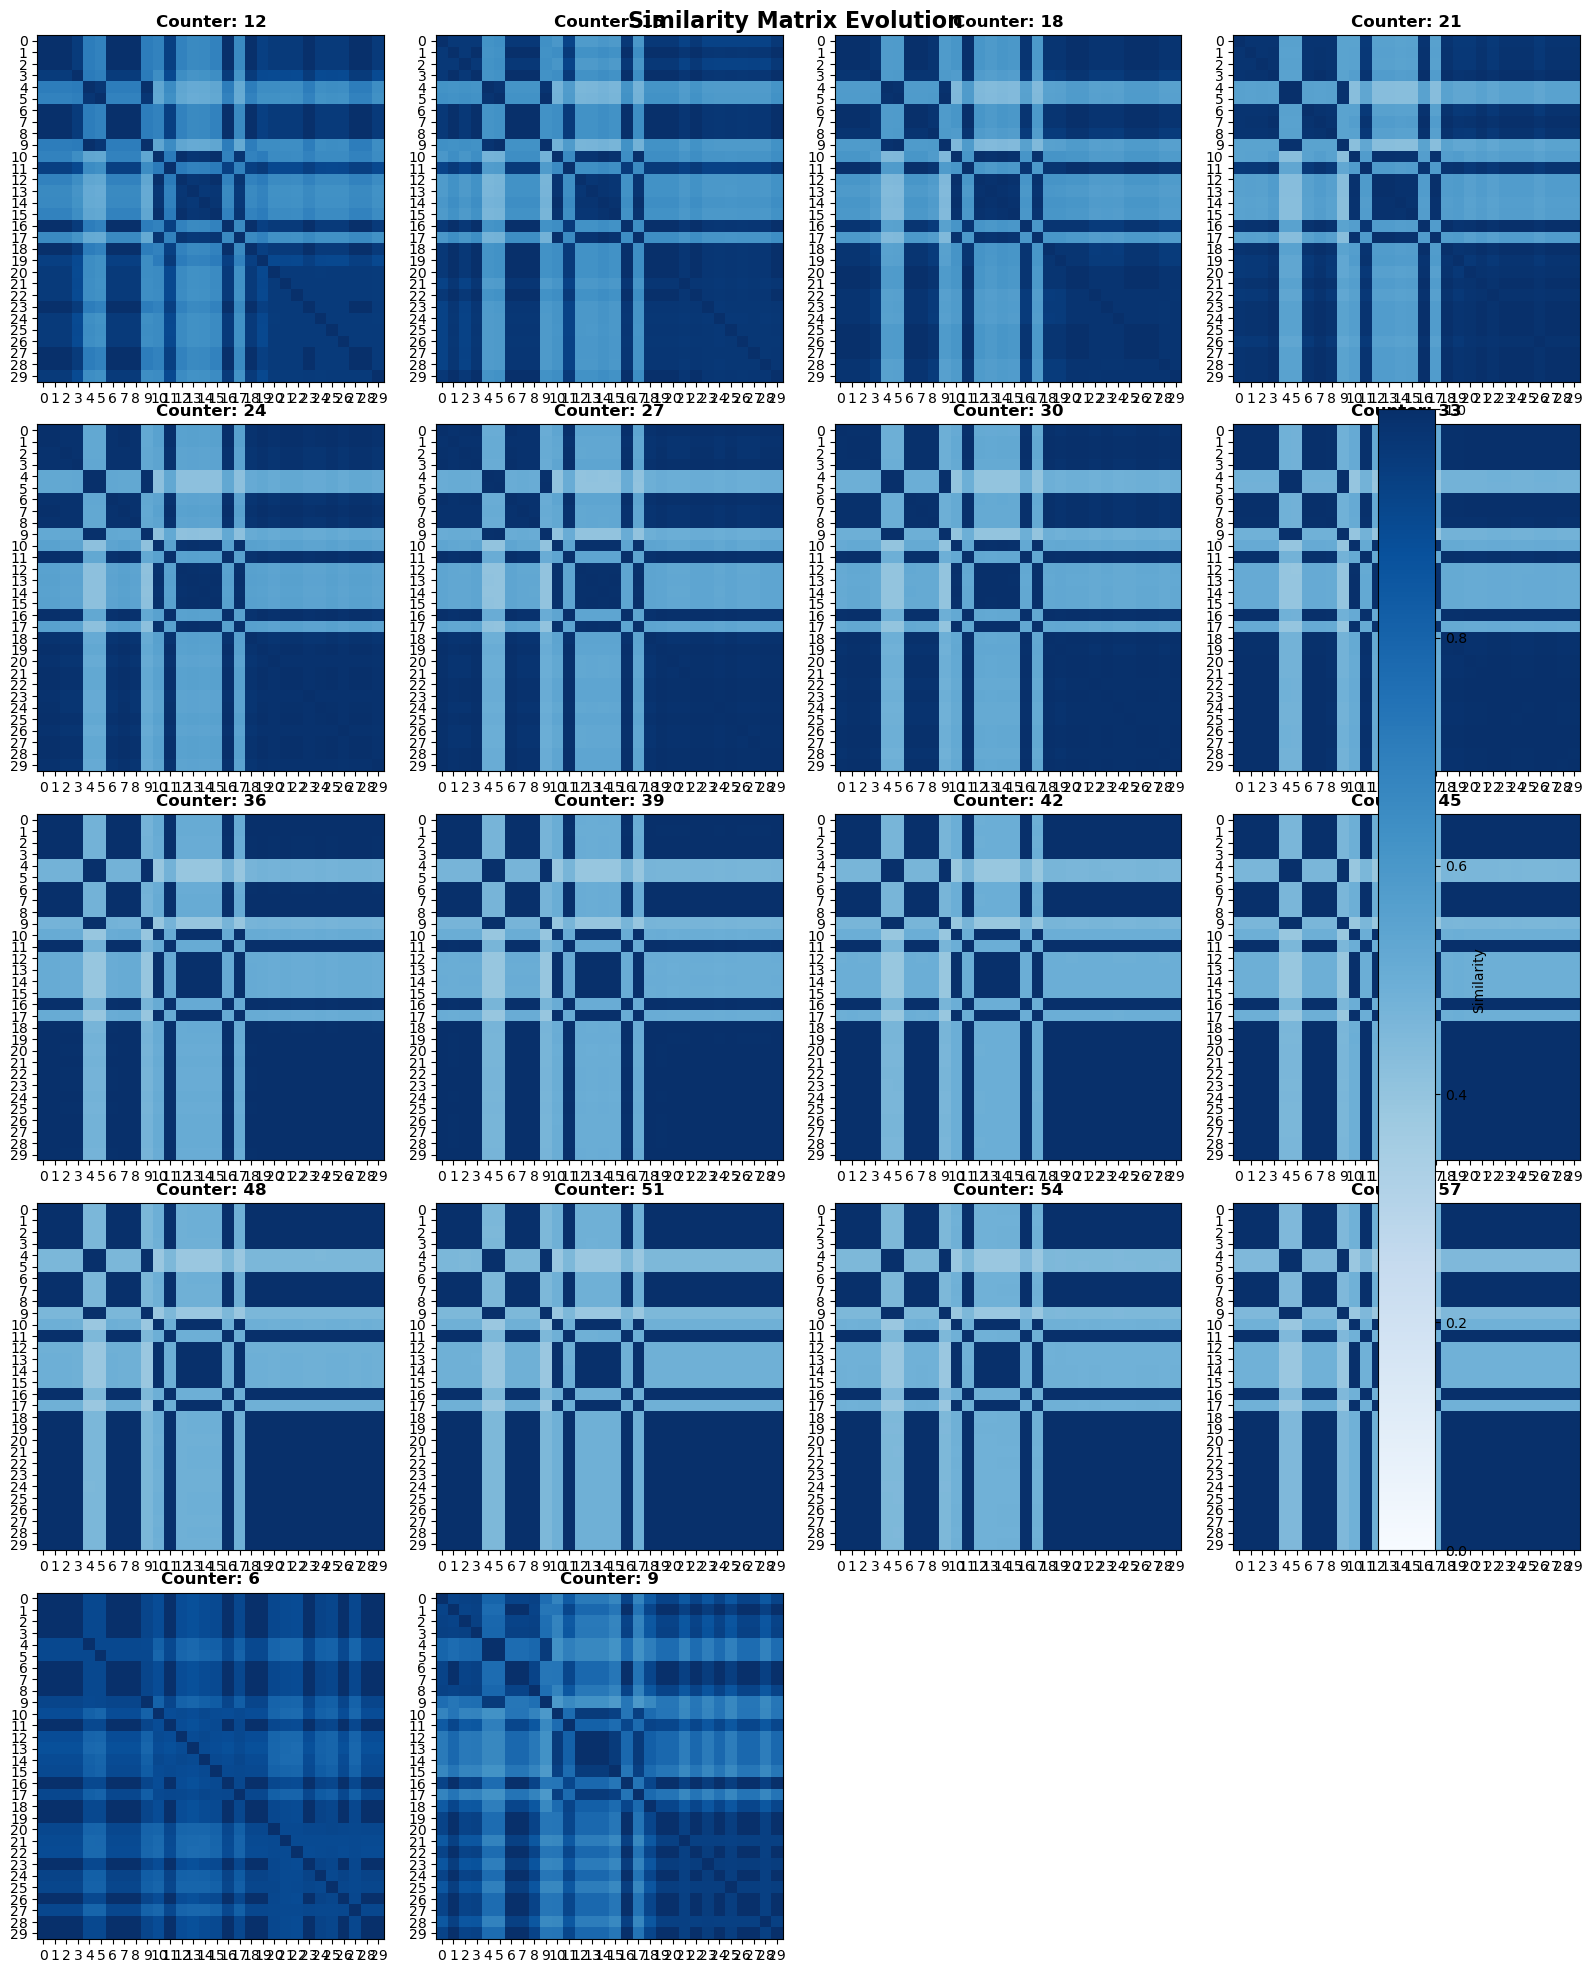

In [4]:
print("Plotting all matrices in a grid...")
plot_all_matrices({k:v for k, v in d['similarity_logs'].items() if int(k) <= 60 })

In [5]:
def animate_matrices(matrices_dict, interval=1000):
    """Create an animation showing matrices sequentially"""
    keys = sorted(matrices_dict.keys())
    
    fig, ax = plt.subplots(figsize=(10, 9))
    matrix = np.array(matrices_dict[keys[0]])
    
    im = ax.imshow(matrix, cmap='Blues', vmin=0, vmax=1)
    title = ax.set_title(f'Counter: {keys[0]}', fontsize=14, fontweight='bold')
    
    # Remove ticks for large matrices
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im, ax=ax, label='Similarity')
    
    def update(frame):
        key = keys[frame]
        matrix = np.array(matrices_dict[key])
        im.set_array(matrix)
        title.set_text(f'Counter: {key} ({frame+1}/{len(keys)})')
        return [im, title]
    
    anim = FuncAnimation(fig, update, frames=len(keys), 
                        interval=interval, blit=True, repeat=True)
    plt.tight_layout()
    plt.show()
    return anim


Creating animation (close window to continue)...


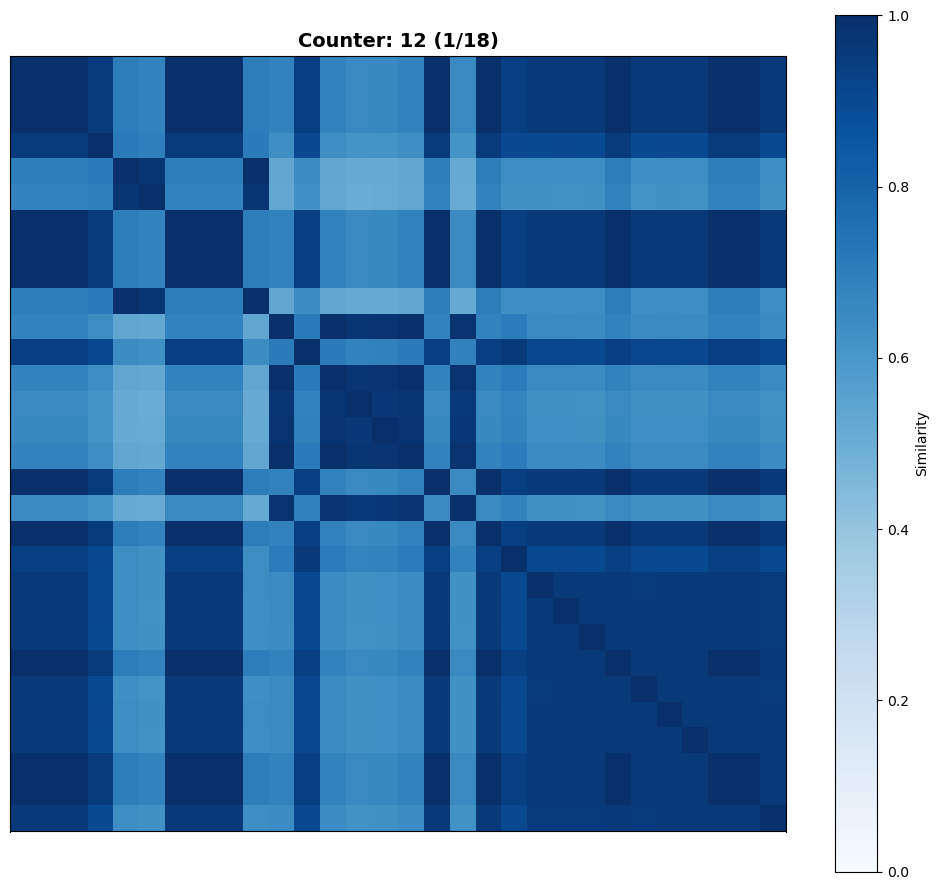

In [6]:
print("\nCreating animation (close window to continue)...")
anim = animate_matrices(similarities, interval=1000)

In [7]:
anim.save("animation_rot_mnist_30c_50p.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


In [32]:
G = nx.Graph()
G.add_nodes_from([ f"c_{i}" for i in range(50)])

for i in range(50):
    for j in range(i+1, 50):
        if similarities["12"][i][j] > 0.9:
            G.add_edge(f"c_{i}", f"c_{j}", weight=similarities['12'][i][j])

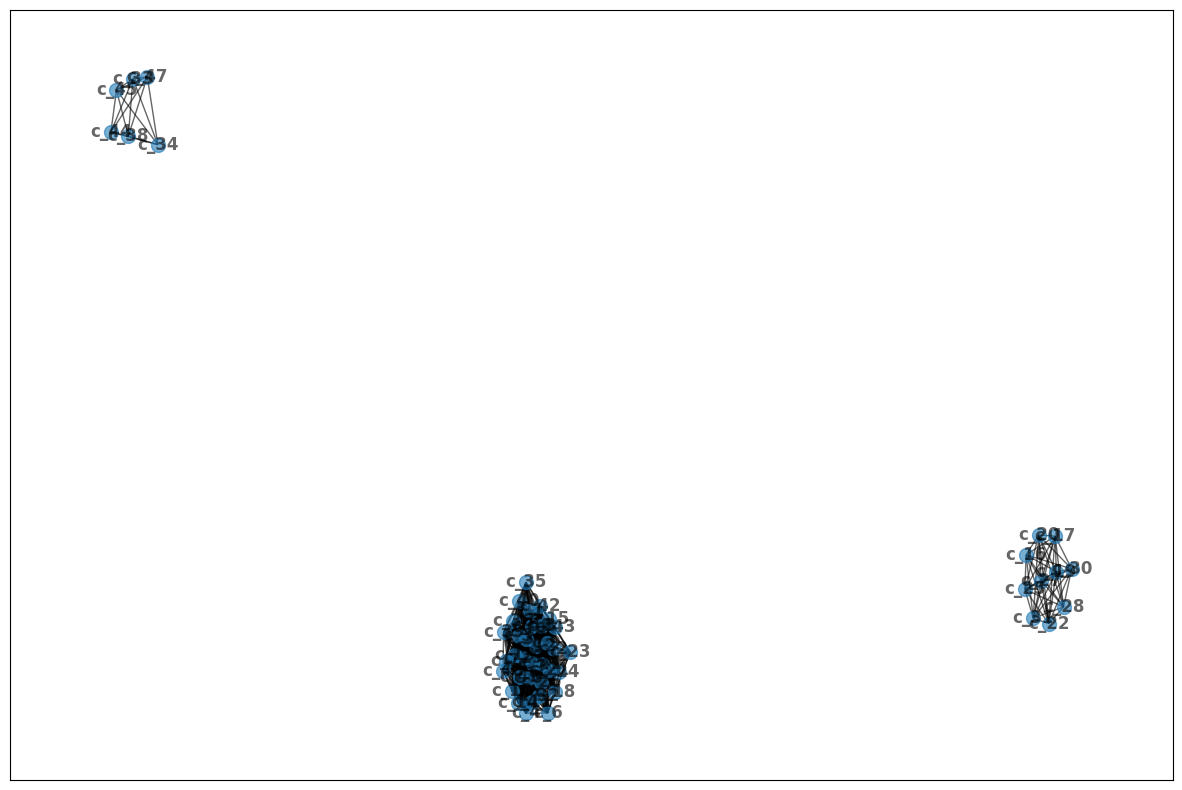

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10), dpi=100)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, node_size=100, alpha=0.6, with_labels=True,  font_weight='bold')
plt.show()

In [41]:
def animate_graphs(matrices_dict, threshold=0.9, interval=1000):
    """Create an animation showing network graphs sequentially"""
    keys = sorted(matrices_dict.keys())
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create initial graph
    matrix = np.array(matrices_dict[keys[0]])
    G = nx.Graph()
    G.add_nodes_from([f"c_{i}" for i in range(len(matrix))])
    for i in range(len(matrix)):
        for j in range(i+1, len(matrix)):  # Avoid duplicate edges
            if matrix[i][j] > threshold:
                G.add_edge(f"c_{i}", f"c_{j}", weight=matrix[i][j])
    
    # Calculate layout once for consistency across frames
    pos = nx.spring_layout(G)
    
    # Draw initial graph
    ax.clear()
    nx.draw(G, pos, ax=ax, 
            node_color='lightblue', 
            node_size=500,
            with_labels=True,
            font_size=8,
            edge_color='gray',
            width=2,
            alpha=0.7)
    title = ax.set_title(f'Counter: {keys[0]} (1/{len(keys)}) - Edges: {G.number_of_edges()}', 
                         fontsize=14, fontweight='bold')
    
    def update(frame):
        ax.clear()
        key = keys[frame]
        matrix = np.array(matrices_dict[key])
        
        # Create new graph
        G = nx.Graph()
        G.add_nodes_from([f"c_{i}" for i in range(len(matrix))])
        for i in range(len(matrix)):
            for j in range(i+1, len(matrix)):
                if matrix[i][j] > threshold:
                    G.add_edge(f"c_{i}", f"c_{j}", weight=matrix[i][j])
        
        # Clear and redraw
        ax.clear()
        nx.draw(G, pos, ax=ax,
                node_color='lightblue',
                node_size=500,
                with_labels=True,
                font_size=8,
                edge_color='gray',
                width=2,
                alpha=0.7)
        ax.set_title(f'Counter: {key} ({frame+1}/{len(keys)}) - Edges: {G.number_of_edges()}',
                    fontsize=14, fontweight='bold')
        
        
    anim = FuncAnimation(fig, update, frames=len(keys),
                        interval=interval, blit=False, repeat=True)
    plt.tight_layout()
    plt.show()
    return anim

In [50]:
angles = [i*(360//3) for i in range(3)]

In [55]:
for i in range(10):
    
    idx = (i // (10 // 3))
    
    angle_l, angle_h = angles[idx%3]-60, angles[idx%3]+60

    print(angle_l, angle_h)


-60 60
-60 60
-60 60
60 180
60 180
60 180
180 300
180 300
180 300
-60 60


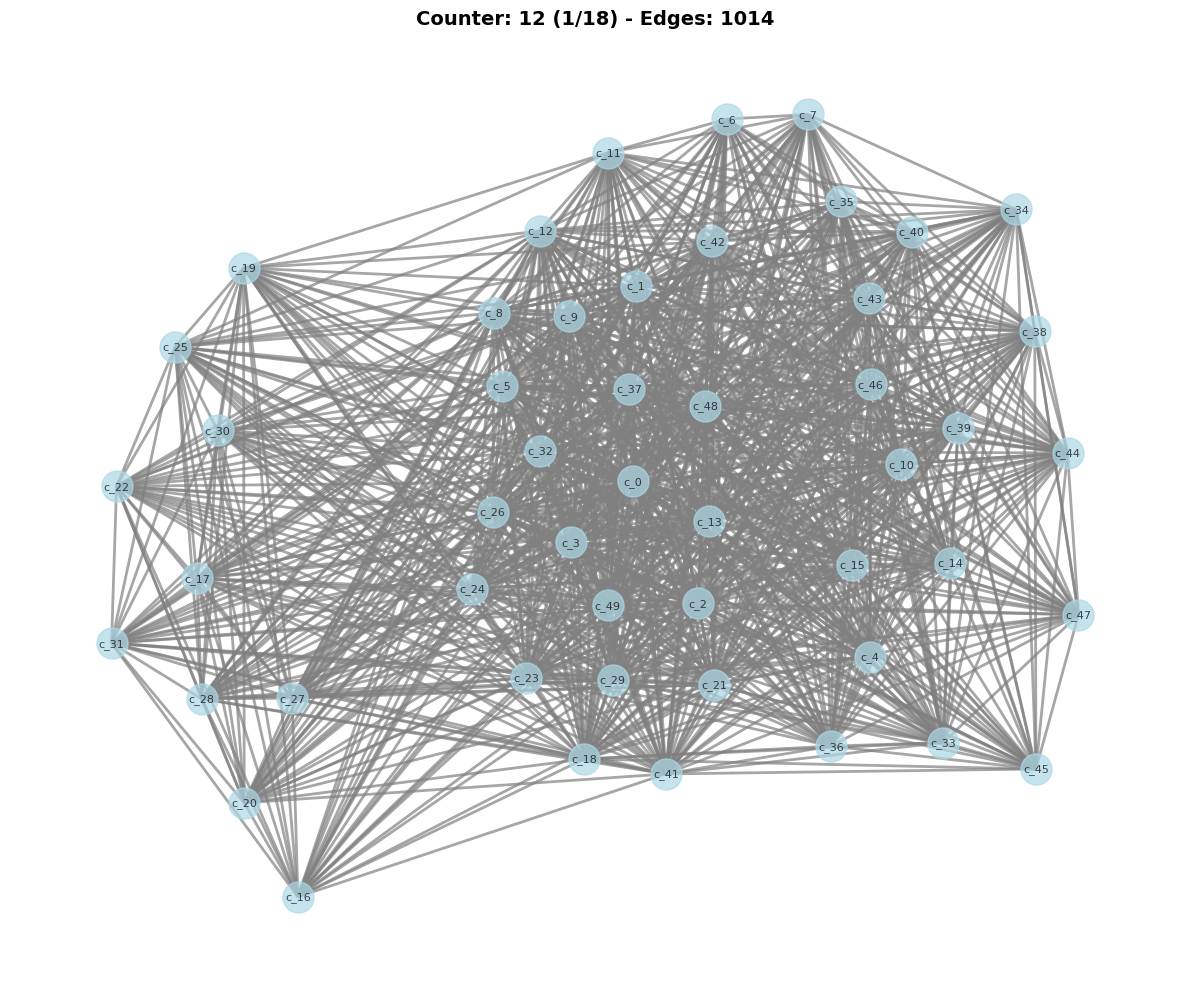

C:\Users\kkire\anaconda3\envs\dl\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [45]:
gr_anim = animate_graphs(similarities, threshold=0.6)

In [43]:
gr_anim.save("gr_animation_mnist_50c_50p.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


In [37]:
similarities.keys()

dict_keys(['6', '9', '12', '15', '18', '21', '24', '27', '30', '33', '36', '39', '42', '45', '48', '51', '54', '57'])

In [144]:
d['config']

{'n_clients': 25,
 'n_clusters': '2',
 'max_clusters': 5,
 'fuzz_clusters': 1,
 'm': 1,
 'method': 'dirichlet',
 'dirichlet_alpha': 0.5,
 'dataset': 'emnist',
 'n_classes': 62,
 'model': 'mnist',
 'client_bs': 1024,
 'global_bs': 1024,
 'global_rounds': 60,
 'client_epochs': 3,
 'client_lr': 0.004,
 'step_size': 2,
 'train_test_split': 0.8,
 'total_train_samples': 70000,
 'total_test_samples': 20000,
 'torch_seed': 42,
 'np_seed': 43,
 'aggl_method': 'silhouette',
 'aggl_linkage': 'ward',
 'fuzzy_thr': 0.8,
 'cluster_every': 3,
 'start_recluster': 10,
 'local_eval_every': 1,
 'verbose': True}

In [216]:
d['logs']['57']

# with 5 clusters the angles should be 0 72 144 216 288 
# out of the above 5 clusters, 0;144 are one cluster and 72;216;288 are other cluster

# this has been the case with other exp as well, when using 3 rotations 0 120 240, only 2 clusters formed: one has 0;120 other had 240

{'cluster': {'0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  '1': [14, 15, 16, 17, 18, 19, 20]},
 'client_4': {'avg_train_loss': 0.4637595779365964,
  'train_loss': 0.3797613441944122,
  'val_acc': 71.64179104477611,
  'val_avg_loss': 1.1005310267210007},
 'client_6': {'avg_train_loss': 0.5195518533388773,
  'train_loss': 0.4126898217946291,
  'val_acc': 60.42296072507553,
  'val_avg_loss': 1.182698667049408},
 'client_3': {'avg_train_loss': 0.7640363857859657,
  'train_loss': 0.6369133336203439,
  'val_acc': 51.785714285714285,
  'val_avg_loss': 1.449260413646698},
 'client_5': {'avg_train_loss': 0.6160627921422323,
  'train_loss': 0.517967567841212,
  'val_acc': 64.02640264026402,
  'val_avg_loss': 1.2180137038230896},
 'client_8': {'avg_train_loss': 0.6438016807421659,
  'train_loss': 0.5411930313477149,
  'val_acc': 66.14268440145102,
  'val_avg_loss': 1.1500132381916046},
 'client_11': {'avg_train_loss': 0.5273668510573252,
  'train_loss': 0.41362214727061136,
  'val_acc': 